# 1번 머신러닝 문제 


* 데이터 설명 : 신용카드 사기 탐지를 위한 예제 데이터이다. 
1. Time : 트랜잭션 시간, 의미 없음  
2. V1~V28 :사용자 ID 및 민감한 기능(v1-v28)을 보호하기 위해 변환된 정보 
3. Amount : 거래금액 
4. Class : 0은 정상, 1은 이상치(신용카드 사기) 

## 1-1 EDA 
## 1-2 상관관계 시각화 전처리 필요함을 설명 

In [ ]:
print('''데이터 전처리 과정
1) EDA
      1. 데이터타입 확인 
      2. 이상치, 결측치 확인
      3. 클래스에 따른 값 범위의 통계적 확인
      3. 변수 간 상관관계 확인
      4. 다중공선성 확인
      5. 클래스 불균형 여부 확인
2) 전처리
      1. scaling 및 one-hot인코딩 처리
      2. 차원축소 시행
      3. 클래스 불균형 처리
''')

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 9
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

from scipy.stats import zscore
pd.set_option('display.max.columns', 20) 

df= pd.read_csv("https://raw.githubusercontent.com/ADPclass/ADP_book_ver01/main/data/27_problem1.csv")
df.shape

(1193, 20)

In [4]:
def describeEx(data):
    desc = data.describe().T
    for i, col in enumerate(data.columns):
        outliers = data[np.abs(zscore(data[col])) > 3][col].sort_values()
        desc.loc[col,'type'] = str(data[col].dtype)
        desc.loc[col,'No.of.outliers'] = outliers.size
        desc.loc[col,'outliers min'] = 0 if outliers.size==0 else outliers.values[0]
        desc.loc[col,'outliers max'] = 0 if outliers.size==0 else outliers.values[outliers.size-1]
        desc.loc[col,'No.of.NAs'] = data[col].isna().sum()
    return desc

desc = describeEx(df)
desc
print('''각 설명변수의 값 분포 및 데이터 타입, 결측치, 이상치를 한번에 확인한다.
''' )

각 설명변수의 값 분포 및 데이터 타입, 결측치, 이상치를 한번에 확인한다.




pd.melt 함수는 주어진 dataframe을 3개의 요소 열로 재편해준다.
      기본적으로 여러 개의 변수열(value_vars)에 값이 들어있을 때, [variable:value]의 짝으로 재편하는데, 이 짝에 부여할 id가 있는 경우 id_vars로 할당해준다.
      따라서 기본적으로 value_vars만 사용하거나, id_vars를 함께 사용하게 된다.
      [변수:값] 짝에 각각 이름을 부여하고 싶은 경우 var_name, value_name을 써서 이름을 할당한다.
    id_vars는   



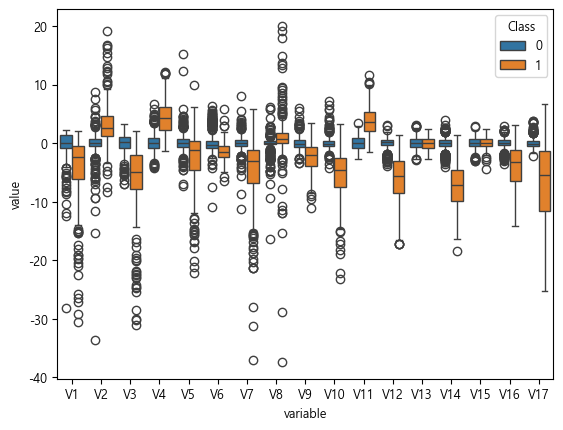

In [5]:
temp = pd.melt(df, id_vars='Class', value_vars=['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10','V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17'])
sns.boxplot(hue='Class', x='variable', y='value', data=temp)

print('''
pd.melt 함수는 주어진 dataframe을 3개의 요소 열로 재편해준다.
      기본적으로 여러 개의 변수열(value_vars)에 값이 들어있을 때, [variable:value]의 짝으로 재편하는데, 이 짝에 부여할 id가 있는 경우 id_vars로 할당해준다.
      따라서 기본적으로 value_vars만 사용하거나, id_vars를 함께 사용하게 된다.
      [변수:값] 짝에 각각 이름을 부여하고 싶은 경우 var_name, value_name을 써서 이름을 할당한다.
    id_vars는   
''')

In [ ]:
plt.subplots(1,1, figsize=(12, 12))
sns.heatmap(df.corr(), annot=True)

print('''아래 heatmap에서 보면 
      - 검은 색 계통은 높은 음의 상관관계를 보여주고, 노란색이 옅을 수록 높은 양의 상관관계를 보여준다.
      - V2, V4, V16, V17 등이 다른 기타 설명변수들과 높은 상관관계를 보인다.
      - 실제적으로 문제가 되는 수준일 지 다중공선성 평가가 필요하다.''')


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df.drop(['Class', 'Time'], axis=1)

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif = vif.sort_values(by='VIF Factor')

print('''아래 표에서 보듯 5개의 설명변수가 VIF 계수 5를 초과한다.  
      - V14, V3, V10, V16, V12, V17, V7이고 이 중 V7은 거의 10에 해당한다.
      - 10을 초과하지는 않으므로 반드시 제거할 필요는 없으나, 차원축소 시 모델 성능을 평가해볼 필요가 있다.''')
vif

# 1-2 전처리가 필요함 설명 


* 이 데이터 세트는 25,446건의 거래 중 492건의 사기가 있는 거래를 나타냅니다.
* 데이터 세트는 매우 불균형하며 긍정적인 클래스(사기)가 모든 거래의 1.93%를 차지합니다.

1. 변수별로 이상치가 존재하나, 이상치를 찾아 처리하는 과제이므로 이상치를 제거하지는 않는다. 
2. 변수간의 상관성이 높아 전처리가 필요한 것은 없어보인다. 
3. Class 변수의 수를 보면 1이 현저히 작게 분포되어, 클래스의 불균형이 있음을 알 수 있다. 
  - 오버샘플링 or 언더 샘플링으로 처리가 필요해 보인다. 
4. Amount의 경우 다른 변수들과의 수치 값의 차이가 커 모델 사용시, scale을 적용할 필요가 있어 보인다. 


# 2번문제 

## 2-1 차원축소 방법 2가지 이상 비교하고 한가지 선택 
- 주성분분석과 요인분석의 공통점
    - 변수축소 기능 
    - 데이터의 성질과 특징 탐색
    - 다중공선성의 처리되므로 회귀분석 용이
    - 차원축소 후 군집분석 시 속도 향상
    - 차원축소 후 시계열 분석 시 용이
- 주성분분석과의 차이점
    - PCA는 데이터의 분산을 가장 많이 설명하는 축/평면을 찾아내는 것임.
        - 따라서 도출된 순서대로 기여도(설명력)의 차이가 발생함.
        - 따라서 주성분의 개수는 누적 기여도에 따라 임의로 정함
        - 의미 불문, 분산이 설명력이 높은 축/평면을 찾은 것이므로 이름을 붙일 수 없음.
    - FA는 개념적/논리적으로 비슷한 특성들을 묶어 만드는 것임
        - 따라서 도출된 순서는 설명력과 상관이 없고, 우선순위도 없음.
        - 따라서 요인의 개수는 제한이 없고, 분석 과정에서 결정이 됨
        - 개념적/논리적 의도를 전제하므로 하위 변수들을 토대로 이름을 명명함.
- 주성분분석은 차원 축소를 목적으로, 데이터의 분산을 최대한 잘 설명할 수 있는 성분을 다른 설명변수들의 가중선형으로 만들어내는 것이다. 그리고 남은 분산을 가장 잘 설명하는 성분을 추출하기 위해 첫번째 성분에 직교하는 방식으로 추출한다. 따라서 해당 성분에 어떤 개념/의미를 부여할 수는 없다.
- 요인분석의 경우는 여러 설명변수에 공통적으로 영향을 주고 있는 성분을 추출하고자 하는 것이다. 각 설명변수들은 이 공통요인에 일정한 편차가 더해지는 방식으로 설명될 수 있다. 따라서 이 공통요인은 문제의 영역에 따라 개념지워질 수 있는 경우가 많지만, 그 중요도, 우선순위는 매길 수 없다.
- 이 사례에서는 설명변수가 너무 많고 서로 상관관계를 갖는 경우가 많은 것으로 보이지만, 익명화로 인해 도메인 특성을 이해할 수 없는 상황이므로 주성분 분석이 더 맞는다.

## 2-2 추천한 한가지를 실제로 수행하고 선택한 이유 설명 

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

features = df.drop(['Time', 'Class', 'Amount'], axis=1)

# 변수간의 스케일이 차이가 나면 스케일 큰 변수가 주성분에 영향을 많이 주기 때문에 주성분 분석 전에 변수를 표준화한다.
# 해당 데이터의 v1 - v28은 값의 큰 차이가 없으므로 Amount만 -1~1 값으로 표준화 시키도록 하겠다. 
minmax= MinMaxScaler(feature_range=(-3,3))
features['Amount'] = minmax.fit_transform(df[["Amount"]])

pca = PCA(n_components=features.shape[1], svd_solver='auto')
pca_fit = pca.fit(features)

#전체 분산의 80%를 설명하기 위해 필요한 주성분 개수로 결정
e_value = pd.DataFrame({'고유값':pca_fit.explained_variance_, '기여율':pca_fit.explained_variance_ratio_})
e_value['누적기여율'] = e_value['기여율'].cumsum()

print('''주성분 개수를 정하는 방식으로, 전체 기여율이 80%를 초과하는 선에서 결정하는 방식이 있다.
      주성분을 기여율이 큰 것부터 4개를 사용하면 전체 분산의 83%가 설명된다.
      따라서 필요한 주성분 개수를 4개로 설정할 수 있다.
''')
e_value

주성분 개수를 정하는 방식으로, 전체 기여율이 80%를 초과하는 선에서 결정하는 방식이 있다.
      주성분을 기여율이 큰 것부터 4개를 사용하면 전체 분산의 83%가 설명된다.
      따라서 필요한 주성분 개수를 4개로 설정할 수 있다.



,고유값,기여율,누적기여율
0,82.369767,0.662378,0.662378
1,9.812672,0.078909,0.741287
2,6.545275,0.052634,0.793921
3,4.857248,0.039060,0.832980
4,4.600214,0.036993,0.869973
5,2.495256,0.020066,0.890039
6,1.975951,0.015890,0.905928
7,1.696062,0.013639,0.919567
8,1.553235,0.012490,0.932058
9,1.428780,0.011490,0.943547


Text(0.5, 1.0, 'Scree plot')

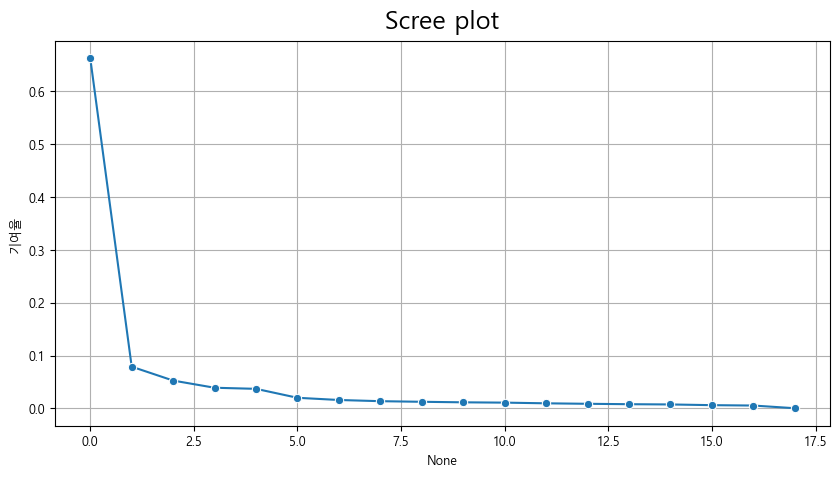

In [9]:
# PCA 고유값 기여율로 Scree plot을 그렸을 때 기울기가 완만해지는 지점으로 주성분 개수 결정
fig, ax = plt.subplots(1, 1, figsize=(10,5))
sns.lineplot(x=e_value.index, y='기여율', marker='o', data=e_value, ax=ax)
ax.grid()
ax.set_title('Scree plot', fontsize=18, pad=9)


- 우선, 해당 데이터의 의미를 정확하게 이해하고 있지 못할 때에는 분석가의 주관적인 견해가 들어가는 요인분석은 사용하기가 어렵다. (미리 가정을 하고 분석하는 것에 어울림) 
- PCA는 데이터간의 선형 관계만을 가지고 판단하고, 주어진 데이터를 최대한 보존하여 저차원의 데이터를 얻을 수 있으므로 지금과 같은 가명처리 되어있는 변수에 적합한 기법이라 판단하였다. 

## 3.오버샘플링/언더샘플링

3.1 오버샘플링과 언더샘플링 장단점 비교 및 선택 구현

3.2 분류 분석에 대한 구현 및 알고리즘 2가지 (오버샘플링, 언더샘플링) 비교, 성능 측정

3.3 현재까지 전처리한 데이터를 통해 분류 모델 수행 후 결과 분석

In [ ]:
print('''
오버샘플링(업샘플링)하는 기법에는 다음과 같은 것이 있다.
      1. 랜덤 오버샘플링
        - 적은 쪽 클래스의 샘플을 랜덤 샘플링하여 복제하는 방식이다. 
        - 복제된 데이터의 가중치를 높이는 효과가 있어, 과적합 우려가 있다.
      2. SMOTE(Synthetic Minority oversampling technique)
        - 우선 KNN을 이용하여 클러스터링을 수행한다.
        - 적은 쪽 클래스의 데이터를 랜덤 샘플링한 후, 해당 샘플 주위 k개의 이웃들을 찾는다.
        - 이 샘플과 k개의 이웃 사이의 속성을 갖는 새로운 샘플을 생성한다.
      3. Borderline SMOTE
        - SMOTE를 시행하는데, 이 때 랜덤샘플링이 아니라 클래스를 구분짓는 경계면(Borderline)에 위치한 데이터를 샘플링한다.
        - 먼저 적은 클래스의 데이터를 랜덤샘플링 후 이웃 k개를 찾아내는데, 이 중 많은 클래스가 있다면 경계면 데이터로 판정.
        - 이 경계면 데이터에 대해 SMOTE를 적용한다.
언더샘플링(다운샘플링)하는 기법에는 다음과 같은 것이 있다.
      1. 랜덤 언더샘플링
        - 많은 클래스의 데이터를 랜덤 샘플링하여 제거하는 방식이다.
      2. 토멕링크(Tomek Links)
        - 토멕링크란 서로 다른 클래스의 데이터를 연결하는 선인데, 해당 선 길이보다 더 짧게 연결할 수 없을 때 이를 토멕링크라고 한다.
        - 토멕링크에 해당하는 많은 클래스의 데이터를 제거하여, 클래스 간 구분선을 보다 명확하게 한다.
      3. CNN (Condensed Nearest Neighbor)
        - 소수 Class 전체 + 다수 Class에서 무작위로 하나의 관측치 A를 선택
        - 원데이터에 대한 1-NN 적용분류하는데 소수클래스 쪽에 가까운 데이터만 남기고, A에 가까운 데이터를 삭제
        - 이렇게 함으로써 분류 성능에 큰 영향이 없는 데이터를 삭제하고, 클래스간 경계면이 데이터를 남기는 방식을 취한다.
      
이 사례에서는 아래 보는 바와 같이 정상거래와 사기거래의 비율이 5:1 정도이다. 
      언더샘플링 하기에는 이상 데이터의 수가 너무 적고, 정상 데이터에 대한 정보 손실이 너무 크므로, 오버샘플링을 선택한다.
''')
df.Class.value_counts()

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import BorderlineSMOTE, SMOTE

target = df.Class

print('''먼저 이 데이터에 가장 잘맞는 RandomForestClassifier의 하이퍼 파라미터를 찾아둔다.
''')
model_rfc = RandomForestClassifier(n_estimators=100)
param_rfc = {   'max_depth': [5, 10, 20],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]}

gs_rfc = GridSearchCV(model_rfc, param_grid=param_rfc, cv=4)
gs_rfc.fit(features, target)

print(f'RandomForestClassifier Best param {gs_rfc.best_params_}')
print(f'RandomForestClassifier Best score {gs_rfc.best_score_}')

먼저 이 데이터에 가장 잘맞는 RandomForestClassifier의 하이퍼 파라미터를 찾아둔다.

RandomForestClassifier Best param {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
RandomForestClassifier Best score 0.9740101232295572


      BorderlineSMOTE     SMOTE  original
PCA          0.939638  0.963783  0.963211
none         0.971831  0.961771  0.956522


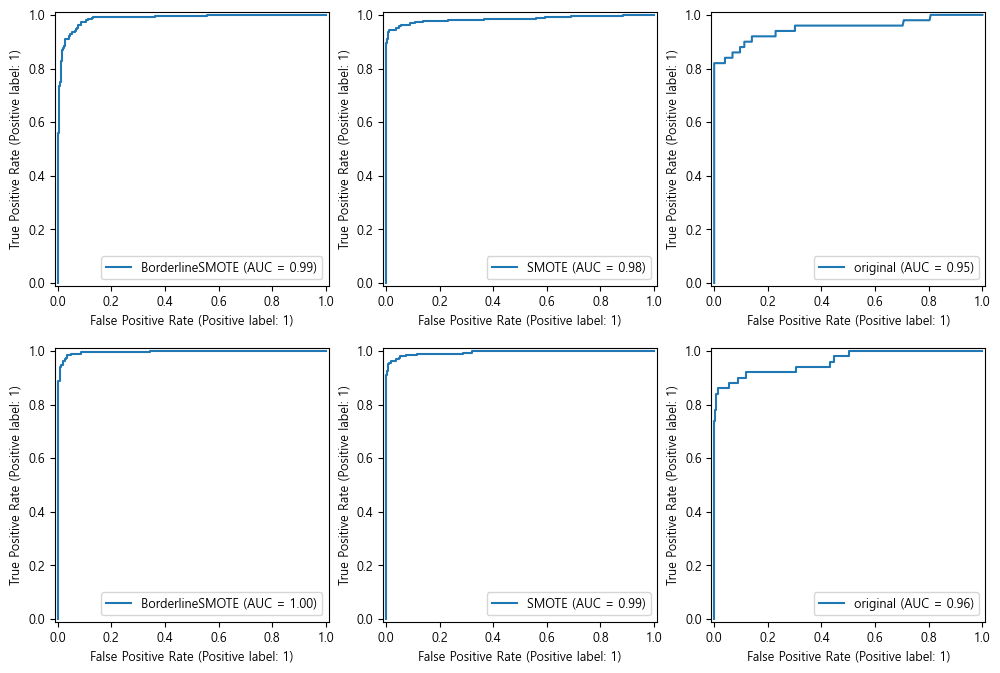

위 표에서 보는 바와 같이,
      - over-sampling을 하지 않을 때는 PCA를 적용하는 것이 더 나은 효과를 보였다.
      - over-sampling을 하는 경우는 PCA를 적용하지 않는 것이 더 나은 효과를 보이며,
      - 전체적으로 봤을 때, over-sampling 후 PCA는 적용하지 않는 것이 가장 나은 성능을 보인다.
      - ROC-AUC 상으로 볼 때, BordrerlineSMOTE 적용 over-sampling하고 PCA를 적용하지 않을 때 가장 좋은 분류 성능을 보인다.



In [12]:
best_dim = 6
pca = PCA(n_components=best_dim, svd_solver='auto')

bsmt = BorderlineSMOTE()
Xb, yb = bsmt.fit_resample(features, target)

smt = SMOTE()
Xs, ys = smt.fit_resample(features, target)

Xlist = [Xb, Xs, features]
ylist = [yb, ys, target]
namelist = ['BorderlineSMOTE', 'SMOTE', 'original']

fig, ax= plt.subplots(2, 3, figsize=(12, 8))

pcadf = pd.DataFrame()
for i, (X, y, name) in enumerate(zip(Xlist, ylist, namelist)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11, stratify=y)

    model_pca = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=2, min_samples_split=2)
    pipe = Pipeline(steps=[('pca',pca), ('model',model_pca)])
    pipe.fit(X_train, y_train)
    pcadf.loc['PCA', name] = pipe.score(X_test, y_test)
    RocCurveDisplay.from_estimator(pipe, X_test, y_test, ax=ax[0][i], name=name)

    model = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=2, min_samples_split=2)
    model.fit(X_train, y_train)
    pcadf.loc['none', name] = model.score(X_test, y_test)

    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax[1][i], name=name)

print(pcadf)

plt.show()

print('''위 표에서 보는 바와 같이,
      - over-sampling을 하지 않을 때는 PCA를 적용하는 것이 더 나은 효과를 보였다.
      - over-sampling을 하는 경우는 PCA를 적용하지 않는 것이 더 나은 효과를 보이며,
      - 전체적으로 봤을 때, over-sampling 후 PCA는 적용하지 않는 것이 가장 나은 성능을 보인다.
      - ROC-AUC 상으로 볼 때, BordrerlineSMOTE 적용 over-sampling하고 PCA를 적용하지 않을 때 가장 좋은 분류 성능을 보인다.
''')
    

## 4.1 이상탐지 모델 2가지 이상 기술 장/단점 설명 

### 1. DBSCAN - 비지도 학습
- 특징
    - 클러스터가 더 낮은 밀도의 영역으로 분리된 공간의 밀도가 높은 영역이라는 가정하에 작동한다.
    - 데이터를 클러스터링하기 위해 DBSCAN 알고리즘은 데이터의 고밀도 영역과 저밀도 영역을 분리합니다. 거리와 군집당 최소 데이터 수를 사용하여 이상 데이터를 특이치로 분류합니다
- 장/단점 
    - DBSCAN의 경우 주변 데이터에서 멀어지는 데이터의 특징을 찾아서 Class를 분류하기에 0 or 1이 아닌 특이점이라도 발견 할 수 있다. 아웃라이어를 탐색하는데에 적합하다. 
    - 하지만, 데이터의 특성을 잘 파악하여 군집 밀도와 최소 데이터 수 등 파라미터를 조정하는 것이 어려운 단점이 있다. 


### 2. SVM - 지도학습 방식
- 특징
    - 데이터를 선형모델을 분류하고자 할 때, 선형으로 완전히 분류할 수 없는 데이터의 차원을 올려주어 선으로 분류할 수 있게 커널트릭을 사용하여 데이터를 분류하는 방법이다. 
    - SVM 분류 모델은 데이터 공간에 존재하는 경계로 표현되며, 데이터를 분류하는 여러 경계 중에서 가장 큰 마진으로 갖는 경계를 찾는다. 
    - 이 경계를 이용하여 이상치 Class1을 찾을 때에 이 모델을 사용할 수 있다. 
- 장/단점 
    - SVM의 경우는 비선형 분류에도 사용되어 오류 데이터에 대한 영향이 거의 없으므로, 과적합되는 경우가 적다. 즉, 오류가 많을 경우에는 해당 모델이 강점을 보일 수 있다. 
    - 하지만, SVM은 학습속도가 느리고,  해석이 어렵고 복잡한 모델이라는 단점이있다. 

### DBSCAN 적용

- DBSCAN 이상탐지를 이용하기 위해서 적절한 epsilon 과 minPoints 값을 찾아야 한다. 
- epsilon 의 경우 K-distance 그래프를 사용하여 판단할 수 있다. 
- K 거리 그래프를 그리려면 데이터 세트의 모든 데이터 포인트에 대해 포인트와 가장 가까운 데이터 포인트 사이의 거리가 필요한데, sklearn.neighbors 에서 NearestNeighbors를 사용하여, 거리를 알 수 있다.

In [54]:
from sklearn.neighbors import NearestNeighbors
import numpy as np 

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(features)
distances, indices = nbrs.kneighbors(features)
 #거리 변수는 데이터 세트의 모든 데이터 포인트에 대해 데이터 포인트와 가장 가까운 데이터 포인트 사이의 거리 배열을 포함

distances_sort = np.sort(distances, axis=0)
distances_sort = distances_sort[:,1]

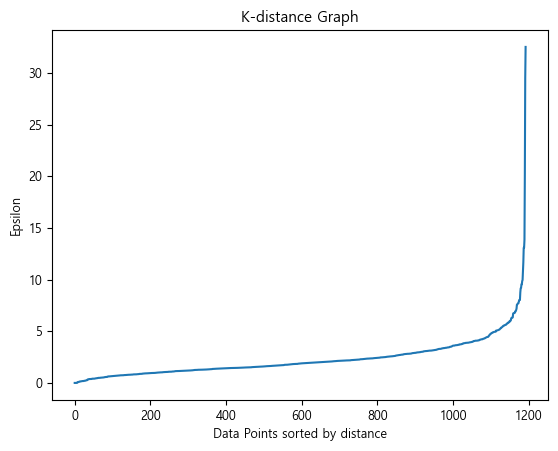

In [55]:
# Plotting K-distance Graph
plt.plot(distances_sort)
plt.title('K-distance Graph')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('Epsilon')
plt.show()

- 엡실론 의 최적 값은 K-거리 그래프에서 최대 곡률 지점에 있으며 이 경우 4~6정도로 지정해주겠습니다. 
- 이제 minPoints의 값을 찾아야 하는데, 이 것도 도메인 지식에 따라 다릅니다. 이번에는 10으로 사용합니다.

- 모델이 취하는 두 가지 가장 중요한 매개변수 값은,
    - (i) 두 포인트 사이의 거리를 지정하는 eps 입니다. 즉, 클러스터의 일부로 간주되기 위해 데이터 포인트가 서로 얼마나 가까워야 하는지를 지정합니다. 
    - (ii) min_samples는 포인트가 클러스터에 있어야 하는 최소 이웃 수를 지정합니다.

In [58]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

db = DBSCAN(eps=4, min_samples=10).fit(features)
labels = db.labels_

print('''
DBSCAN에서는 일련의 데이터 그룹 중 동떨어진 그룹에 대해 -1로 라벨링한다.
아래 표에서 보는 바와 같이 -1로 라벨링된 데이터 중 164개가 실제 이상거래이다.
      - 이상거래 200건 중 164를 식별해내었고, 36건을 오탐지했다.
      - 정상거래 993건 중 901건을 정상 식별하였고, 92건을 오탐지하였다.''')

data = pd.DataFrame()
data["Class"] = target.copy()
data["labels"] = labels
data.loc[data["labels"]==-1,'Class'].sum()

data.groupby('labels').value_counts()


DBSCAN에서는 일련의 데이터 그룹 중 동떨어진 그룹에 대해 -1로 라벨링한다.
아래 표에서 보는 바와 같이 -1로 라벨링된 데이터 중 164개가 실제 이상거래이다.
      - 이상거래 200건 중 164를 식별해내었고, 36건을 오탐지했다.
      - 정상거래 993건 중 901건을 정상 식별하였고, 92건을 오탐지하였다.


labels  Class
-1      1        164
        0         92
 0      0        901
        1         26
 1      1         10
Name: count, dtype: int64

In [48]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

## CM을 그리기 위해서 -1을 Class와 같이 1로 변경) 
data.loc[data.labels==-1, "labels"] = 1
print(f'Confusion Matrix \n{confusion_matrix(data.Class,data.labels)}\n')

accuracy = metrics.accuracy_score(data.Class,data.labels)
print("정확도:", accuracy)

precision = metrics.precision_score(data.Class,data.labels)
print("정밀도:", precision)

recall = metrics.recall_score(data.Class,data.labels)
print("재현율:", recall)

f1 = metrics.f1_score(data.Class,data.labels)
print("f1 점수:", f1)

Confusion Matrix 
[[901  92]
 [ 26 174]]

정확도: 0.901089689857502
정밀도: 0.6541353383458647
재현율: 0.87
f1 점수: 0.7467811158798283


### KNN 분류 적용

In [73]:
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=11, stratify=target)

best_dim = 6
pca = PCA(n_components=best_dim, svd_solver='auto')
knn = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)

pipe = Pipeline([('pca', pca), ('model', knn)])
pipe.fit(X_train, y_train)

print(f'KNN 정확도 : {pipe.score(X_test, y_test)}')

KNN 정확도 : 0.9632107023411371


### SVM 분류 적용

In [81]:
### KNN 분류 적용
from sklearn.svm import SVC

model_svm = SVC()
grid_svm = { 'C': [0.01, 0.05, 0.1, 0.3],               # 에러율 조절 (커지면 과적합)
             'gamma': [0.01, 0.05, 0.1, 0.3],           # 학습정도 조절 (커지면 과적합)
             'kernel': ['linear', 'rbf']}   # 경계면의 곡선화  

search_svm = GridSearchCV(model_svm, param_grid=grid_svm, cv=5)
search_svm.fit(features, target)

print(f'SVM Best param {search_svm.best_params_}')
print(f'SVM Best score {search_svm.best_score_}')

SVM Best param {'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
SVM Best score 0.9731760486621427


### 결론
- SVM 분류기 사용 시, PCA나 over-sampling 없이도 가장 높은 성능을 보였다.
- over-sampling(BorderlineSMOTE) 적용 시 RandomForest 분류기가 그 다음 높은 성능을 보였다.
- KNN 분류기도 PCA 적용 시 RandomForest와 유사한 수준의 성능을 보였다.
- DBSCAN의 경우는 비지도 학습이면서 90%의 정확도를 보였다.
    - labels 가 -1이면서 Class가 0인 고객은 오탐이긴 하나 위험군으로 분류할 수 있다. 
- 분류 정확도만 보면, 지도학습이 훨씬 성능이 좋아 이상거래 식별이 중요할 때는 유용하지만, 
    - 0과 1의 분류가 아닌 특이/비정정상의 범주를 벗어나는 여러 케이스가 있을 경우에는 분류해내기 어렵다. 
    - DBSCAN과 같은 거리기반 이상치 탐지는 정상으로 분류되지 않은 이상치를 가지고 위험군으로 관리할 수 있는 장점이 있다.
